In [1]:
import sys
sys.path.insert(0, '../')
import LMP19
import numpy as np
import matplotlib.pyplot as plt

# Lorenz `96 coupled slow/fast states example
* Assimilate data every $\Delta T = 0.1$ units.
* Solve L96 with $\Delta t = 0.001$ units.

In [2]:
dT = 0.1
dt = 0.001

L96 = LMP19.Models.L96_23(nK=36,nJ=10)
[b,c,F,h] = [10,10,10,1]

H = np.identity(L96.nDim)

In [3]:
nSteps = 50
Y = L96.get_data(nSteps=nSteps*int(dT/dt),dt=dt)[:,::int(dT/dt)]   #truth
y = H@Y                          

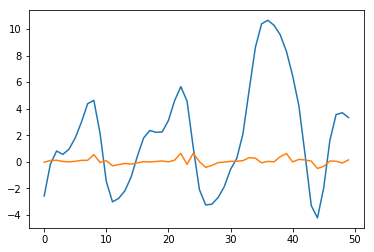

In [4]:
kk = 0
plt.plot(Y[kk,:])
plt.plot(Y[kk*L96.nJ+L96.nK,:])
plt.show()

In [5]:
# Define the localization matrix
L = L96.get_L(0.5)

In [6]:
nE = 10
X_a = np.zeros((L96.nDim,nE,nSteps))
Spread = np.zeros((2,nSteps))
RMSE = np.zeros((2,nSteps))

In [7]:
X_a[:,:,0] = L96.get_data(nSteps=500)[:,np.random.randint(0,500,nE)]

In [8]:
# Define a model that moves the state at time \Delta T * m 
# to \Delta T * (m+1) in incriments of \Delta t 
def Model(x):
    for tt in range(int(dT/dt)):
        x = L96.M(x,)
    return(x)

In [9]:
EnKF = LMP19.Estimation.Sqrt_EnKF(M=Model,nDim=L96.nDim,H=H,L=L,inflation=2)

In [10]:
for kk in range(1,nSteps):
    X_a[:,:,kk] = EnKF.run(X_a[:,:,kk-1],y[:,kk])
    Spread[0,kk] = (np.trace(np.cov(X_a[:L96.nK,:,kk]))/L96.nDim)**0.5
    Spread[1,kk] = (np.trace(np.cov(X_a[L96.nK:,:,kk]))/L96.nDim)**0.5
    RMSE[0,kk] = np.sqrt(np.mean((np.mean(X_a[:L96.nK,:,kk],axis=1)-Y[:L96.nK,kk])**2))
    RMSE[1,kk] = np.sqrt(np.mean((np.mean(X_a[L96.nK:,:,kk],axis=1)-Y[L96.nK:,kk])**2))

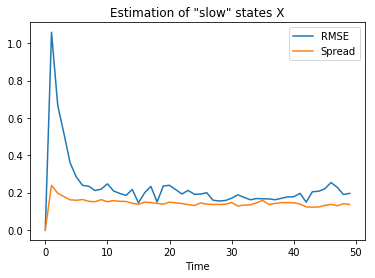

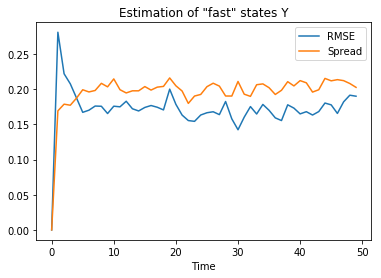

In [15]:
plt.plot(RMSE[0,:],label='RMSE')
plt.plot(Spread[0,:],label='Spread')
plt.xlabel('Time')
plt.legend()
plt.title('Estimation of "slow" states X')
plt.show()

plt.plot(RMSE[1,:],label='RMSE')
plt.plot(Spread[1,:],label='Spread')
plt.xlabel('Time')
plt.legend()
plt.title('Estimation of "fast" states Y')
plt.show()

<IPython.core.display.Javascript object>


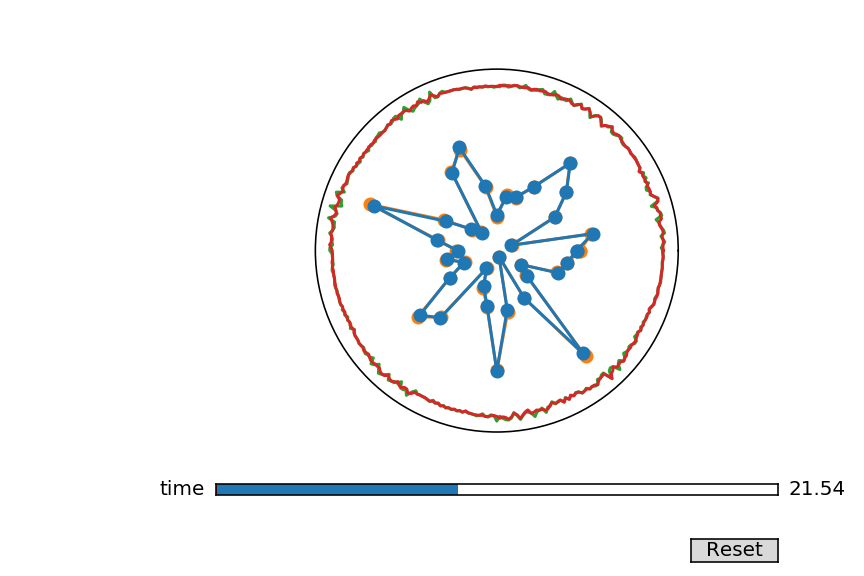

In [18]:
X = np.mean(X_a,axis=1)
from matplotlib.widgets import Slider, Button, RadioButtons
%matplotlib notebook

theta_X = np.linspace(0, 2*np.pi, L96.nK+1)
theta_Y = np.linspace(0, 2*np.pi, L96.nJ*L96.nK+1)

def signal_X(XX,kk):
    Xplt = [val for val in XX[:,int(kk)]]+[XX[0,int(kk)]]
    return(Xplt)
def signal_Y(YY,kk):
    Yplt = [val+14 for val in YY[:,int(kk)]]+[YY[0,int(kk)]+14]
    return(Yplt)

fig = plt.figure()
ax = plt.subplot(111, projection='polar')


# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(left=0.25, bottom=0.25)


# Draw the initial plot
# The 'line' variable is used for modifying the line later
[Y_line2] = ax.plot(theta_X,signal_X(Y[:L96.nK,:],0),color='C1')
[Y_line1] = ax.plot(theta_X,signal_X(Y[:L96.nK,:],0),'o',color='C1')
[Y_line3] = ax.plot(theta_Y,signal_Y(Y[L96.nK:,:],0),'C2')

[X_line2] = ax.plot(theta_X,signal_X(X[:L96.nK,:],0),color='C0')
[X_line1] = ax.plot(theta_X,signal_X(X[:L96.nK,:],0),'o',color='C0')
[X_line3] = ax.plot(theta_Y,signal_Y(X[L96.nK:,:],0),'C3')

# Add sliders for tweaking the parameters

# Define an axes area and draw a slider in it
slider_ax  = fig.add_axes([0.25, 0.14, 0.65, 0.02])
slider = Slider(slider_ax, 'time', 0, Y.shape[1], valinit=0)

# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    data_X = signal_X(Y[:L96.nK,:],slider.val)
    data_Y = signal_Y(Y[L96.nK:,:],slider.val)
    ax.set_yticks([])
    ax.set_xticks([])
    Y_line1.set_ydata(data_X)
    Y_line2.set_ydata(data_X)
    Y_line3.set_ydata(data_Y)
    
    data_X = signal_X(X[:L96.nK,:],slider.val)
    data_Y = signal_Y(X[L96.nK:,:],slider.val)
    X_line1.set_ydata(data_X)
    X_line2.set_ydata(data_X)
    X_line3.set_ydata(data_Y)
    
    fig.canvas.draw_idle()
slider.on_changed(sliders_on_changed)

# Add a button for resetting the parameters
reset_button_ax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
reset_button = Button(reset_button_ax, 'Reset', hovercolor='0.975')
def reset_button_on_clicked(mouse_event):
    slider.reset()
reset_button.on_clicked(reset_button_on_clicked)

plt.show()